<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/persian_VQA_SAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install arabic_reshaper 
! pip install python-bidi

  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.0-cp36-none-any.whl size=16501 sha256=5a6384a914779d9c7eb432d9049532f71488327a71f22b711507145cd8812d74
  Stored in directory: /root/.cache/pip/wheels/a9/e6/ec/2ba48138d4447d40442dd6ba3bf6b92d9c6afd74e9c720c6fe
Successfully built arabic-reshaper


In [3]:
%load_ext tensorboard
!rm -rf ./logs/ 

In [78]:
import os
import re
import json
import numpy as np
from PIL import Image
import arabic_reshaper
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv1D, Dense, Embedding, LSTM, Dropout, Concatenate, Input, Multiply, GlobalMaxPooling1D, Flatten

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [66]:
# DROPOUT_RATE = 0.5
# EMBEDDING_DIM = 100
EPOCHS = 20
# BATCH_SIZE = 64
SEQ_LENGTH = 40
VOCAB_SIZE = 1000
NUM_FILTERS = [256, 256, 512]
FILTER_SIZE = [1, 2, 3]
# ATTENTION_DIM = 301
OOV_TOK = "<OOV>"

HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_EMBEDDING_DIM = hp.HParam('embedding_dim', hp.Discrete([50, 100]))
HP_BATCH_SIZE= hp.HParam('batchsize', hp.Discrete([64, 128]))
HP_ATTENTION_DIM= hp.HParam('attention_dim', hp.Discrete([512, 1024]))


METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_DROPOUT, HP_OPTIMIZER, HP_EMBEDDING_DIM, HP_BATCH_SIZE, HP_ATTENTION_DIM],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

BASE_PATH = '/content/drive/My Drive/Persian_VQA/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'google-train_questions.json')
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'google-train-annotations.json')
IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, '...')
IMAGE_VAL_PATH = os.path.join(BASE_PATH, 'val_images_500')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
IMAGE_TEST_PATH = os.path.join(BASE_PATH, 'test_images_500')

In [7]:
def read_image_paths(dir_path):
  ims = {}

  for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
      image_id = int(re.findall('\d+', filename)[1])
      ims[image_id] = os.path.join(dir_path, filename)

  return ims

In [8]:
def load_and_proccess_image(image_path, model):
  im = load_img(image_path, target_size=(448,448,3))
  x = img_to_array(im)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  # 448 * 448 * 3 -> 512 * 14 * 14
  features = model.predict(x)
  features = np.squeeze(features, axis=0).T
  return features

In [9]:
def read_images(paths):
  ims = {}

  base_model = VGG16(include_top=False, weights='imagenet')
  model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
  
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path, model)
  return ims

In [10]:
def get_train_image_paths():
  return read_image_paths(IMAGE_TRAIN_PATH)

In [11]:
def get_val_image_paths():
  return read_image_paths(IMAGE_VAL_PATH)

In [12]:
def get_test_image_paths():
  return read_image_paths(IMAGE_TEST_PATH)

In [13]:
def create_dataset(ims, qus, ann):
  qs = []
  answers = []
  qs_id = []
  im_id = []

  for q in qus['questions']:
    if q['image_id'] in ims.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])

  for ann in ann['annotations']:
    if ann['question_id'] in qs_id:
      answer_counts = Counter(a['answer'] for a in ann['answers'])
      answers.append(answer_counts.most_common(1)[0][0])

  return qs, answers, qs_id, im_id

In [14]:
def get_train_dataset():
  ims = get_train_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [15]:
def get_val_dataset():
  ims = get_val_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [16]:
def get_test_dataset():
  ims = get_test_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [17]:
def get_answers(answers):
  all_answers = np.unique(answers)
  answer_counts = Counter(a for a in train_answers)
  all_answers =[a[0] for a in answer_counts.most_common(300)]

  return all_answers

In [18]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.axis('off')
  plt.show()

def visualize_train(num):
  ims = get_train_image_paths()
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

def visualize_test(num):
  ims = get_test_image_paths()
  show_visualqa(test_qs[num], test_answers[num], ims.get(test_image_ids[num]))

In [19]:
train_qs, train_answers, train_q_ids, train_image_ids = get_train_dataset()
val_qs, val_answers, val_q_ids, val_image_ids = get_val_dataset()
test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print(len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

print(len(val_qs))
print(len(val_answers))
print(len(val_q_ids))
print(len(val_image_ids))

print(len(test_qs))
print(len(test_answers))
print(len(test_q_ids))
print(len(test_image_ids))

3000
3000
3000
3000
1500
1500
1500
1500
1500
1500
1500
1500


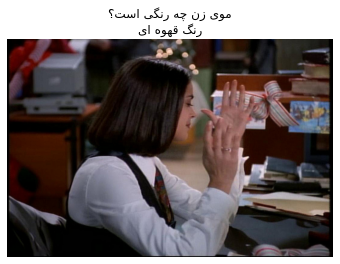

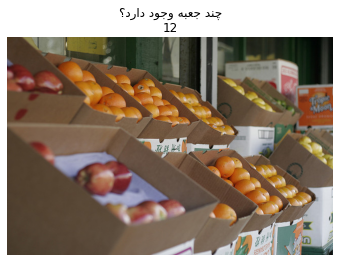

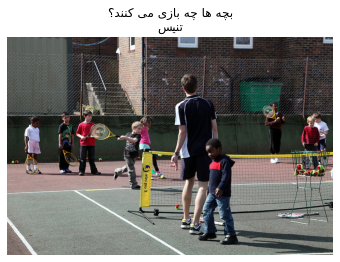

In [20]:
visualize_train(1100)
visualize_train(2200)
visualize_train(600)

In [21]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
word_index = tokenizer.word_index
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_sequences(train_qs)
val_X_seqs = tokenizer.texts_to_sequences(val_qs)
test_X_seqs = tokenizer.texts_to_sequences(test_qs)

train_X_seqs = pad_sequences(train_X_seqs, maxlen=SEQ_LENGTH, padding='post')
val_X_seqs = pad_sequences(val_X_seqs, maxlen=SEQ_LENGTH, padding='post')
test_X_seqs = pad_sequences(test_X_seqs, maxlen=SEQ_LENGTH, padding='post')

train_X_seqs = np.array(train_X_seqs)
val_X_seqs = np.array(val_X_seqs)
test_X_seqs = np.array(test_X_seqs)

In [ ]:
ims = read_images(get_train_image_paths())
train_X_ims = [ims[id] for id in train_image_ids]
train_X_ims = np.array(train_X_ims)
np.save(BASE_PATH + 'train_X_ims_VGG16.npy',train_X_ims)

In [ ]:
ims = read_images(get_val_image_paths())
val_X_ims = [ims[id] for id in val_image_ids]
val_X_ims = np.array(val_X_ims)
np.save(BASE_PATH + 'val_X_ims_VGG16.npy',val_X_ims)

In [ ]:
ims = read_images(get_test_image_paths())
test_X_ims = [ims[id] for id in test_image_ids]
test_X_ims = np.array(test_X_ims)
np.save(BASE_PATH + 'test_X_ims_VGG16.npy',test_X_ims)

In [23]:
train_X_ims = np.load(BASE_PATH + 'train_X_ims_VGG16.npy')
val_X_ims = np.load(BASE_PATH + 'val_X_ims_VGG16.npy')
test_X_ims = np.load(BASE_PATH + 'test_X_ims_VGG16.npy')

In [24]:
print(train_X_ims.shape)
print(val_X_ims.shape)
print(test_X_ims.shape)

(3000, 512, 14, 14)
(1500, 512, 14, 14)
(1500, 512, 14, 14)


In [25]:
all_answers = get_answers(train_answers)
num_answers = len(all_answers)
num_classes = num_answers +1 

train_answer_indices = []
val_answer_indices = []
test_answer_indices = []

for a in train_answers:
  if a in all_answers:
    train_answer_indices.append(all_answers.index(a))
  else:
    train_answer_indices.append(num_answers)
 

for a in val_answers:
  if a in all_answers:
    val_answer_indices.append(all_answers.index(a))
  else: 
    val_answer_indices.append(num_answers)

for a in test_answers:
  if a in all_answers:
    test_answer_indices.append(all_answers.index(a))
  else:
    test_answer_indices.append(num_answers)

train_Y = to_categorical(train_answer_indices)
val_Y = to_categorical(val_answer_indices)
test_Y = to_categorical(test_answer_indices)

print(train_Y.shape)
print(val_Y.shape)

(3000, 301)
(1500, 301)


In [26]:
class image_layer(tf.keras.Model):

  def __init__(self, **kwargs):
    super(image_layer, self).__init__(**kwargs)
    self.dense = Dense(1024, activation='tanh')
  
  def call(self, inputs):
    # N * 512 * 14 * 14 -> N * 512 * 196
    x = tf.reshape(inputs , [-1, inputs.shape[1],inputs.shape[2]*inputs.shape[3]])

    # N * 512 * 196 -> N * 196 * 512
    x = tf.transpose(x, perm=[0,2,1])

    # N * 196 * 512 -> N * 196 * 1024
    x = self.dense(x)

    return x

In [27]:
class question_layer_LSTM(tf.keras.Model):

  def __init__(self,num_words, embedding_dim, dropout_rate, **kwargs):
    super(question_layer_LSTM, self).__init__(**kwargs)
    self.embedding = Embedding(num_words, embedding_dim, input_length=SEQ_LENGTH, trainable = True)
    self.lstm1 = LSTM(units=256, return_sequences=True)
    self.dropout1 = Dropout(dropout_rate)
    self.lstm2 = LSTM(units=256, return_sequences=False)
    self.dropout2 = Dropout(dropout_rate)
    self.dense = Dense(1024, activation='tanh')

  def call(self, inputs):
    # N * SEQ_LENGTH -> N * SEQ_LENGTH * embedding_dim
    x = self.embedding(inputs)

    # N * SEQ_LENGTH * embedding_dim -> N * SEQ_LENGTH * 256
    x = self.lstm1(x)
    x = self.dropout1(x)

    # N * SEQ_LENGTH * 256 -> N * 256
    x = self.lstm2(x)
    x = self.dropout2(x)

    # N * 256 -> N * 1024
    x = self.dense(x)
    return x


In [79]:
class question_layer_CNN(tf.keras.Model):

  def __init__(self,num_words, embedding_dim, filter_size, num_filters, **kwargs):

    super(question_layer_CNN, self).__init__(**kwargs)

    self.embedding = Embedding(num_words, embedding_dim, input_length=SEQ_LENGTH, trainable = True)
    self.conv1 = Conv1D(filters=num_filters[0], kernel_size=filter_size[0], activation='relu', padding='same')
    self.conv2 = Conv1D(filters=num_filters[1], kernel_size=filter_size[1], activation='relu', padding='same')
    self.conv3 = Conv1D(filters=num_filters[2], kernel_size=filter_size[2], activation='relu', padding='same')

    self.dropout = Dropout(rate = 0.5)
    self.maxpooling  = GlobalMaxPooling1D()
    self.flatten = Flatten()

  def call(self, inputs):
    # (N,SEQ_LENGTH) -> (N,SEQ_LENGTH,embedding_dim)
    x = self.embedding(inputs)

    # (N,SEQ_LENGTH,embedding_dim) -> (N,SEQ_LENGTH,NUM_FILTERS)
    h1 = self.conv1(x)
    h2 = self.conv2(x)
    h3 = self.conv3(x)

    # (N,SEQ_LENGTH,NUM_FILTERS) -> (N,NUM_FILTERS)
    h1 = self.maxpooling(h1)
    h2 = self.maxpooling(h2)
    h3 = self.maxpooling(h3)

    # (N, 1024)
    h = Concatenate(axis=1)([h1, h2, h3])

    return h


In [72]:
class attention_layer(tf.keras.Model):

  def __init__(self, attention_dim, **kwargs):
    super(attention_layer, self).__init__(**kwargs)
    self.wi = Dense(units=attention_dim, use_bias=False, activation=None)
    self.wq = Dense(units=attention_dim, activation=None)
    self.wpi = Dense(1, activation='softmax')
    self.dropout = Dropout(0.5)
  
  def call(self, inputs):
    vi, vq = inputs

    # N * 196 * 1024 -> N * 196 * attention_dim
    hi = self.wi(vi)

    # N * 1024 -> N * attention_dim
    hq = self.wq(vq)

    # N * attention_dim -> N * 1 * attention_dim
    hq = tf.expand_dims(hq, axis=1)

    # N * 196 * attention_dim
    ha = tf.tanh(hi + hq)

    ha = self.dropout(ha)

    # N * 196 * attention_dim -> N * 196 * 1
    pi = self.wpi(ha)

    # #  N * 196 * 1 -> N * 196
    # pi = tf.squeeze(pi, axis=2)

    # #  N * 196 -> N * 196
    # pi = tf.keras.activations.softmax(pi)

    
    # vi_att = tf.reduce_sum(tf.expand_dims(pi, axis=2)*vi)

    # # (N * 196 * 1, N * 196 * 1024) -> N * 1024
    vi_att = tf.reduce_sum(pi*vi, axis=1)

    # N * 1024
    u = vi_att + vq

    return u

In [30]:
def SAN_LSTM(num_classes, dropout_rate, num_words, embedding_dim, attention_dim):

  qs_input = Input(shape=(SEQ_LENGTH,))
  img_input = Input(shape=(512,14,14))

  image_embed = image_layer()(img_input)
  ques_embed = question_layer_LSTM(num_words, embedding_dim, dropout_rate)(qs_input)
  att = attention_layer(attention_dim)([image_embed , ques_embed])
  att = attention_layer(attention_dim)([ image_embed , att])
  output = Dense(num_classes, activation='softmax')(att)

  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

In [80]:
def SAN_CNN(num_classes, dropout_rate, num_words, embedding_dim, attention_dim):

  qs_input = Input(shape=(SEQ_LENGTH,))
  img_input = Input(shape=(512,14,14))

  image_embed = image_layer()(img_input)
  ques_embed = question_layer_CNN(num_words, embedding_dim, FILTER_SIZE, NUM_FILTERS)(qs_input)
  att = attention_layer(attention_dim)([image_embed , ques_embed])
  att = attention_layer(attention_dim)([ image_embed , att])
  output = Dense(num_classes, activation='softmax')(att)

  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

In [81]:
model = SAN_CNN(num_classes, 0.5, VOCAB_SIZE, 100 , 1024)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit([train_X_seqs, train_X_ims] ,
                    train_Y, 
                    epochs = 50, 
                    batch_size = 64, 
                    validation_data=([val_X_seqs, val_X_ims], val_Y) )

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_92 (InputLayer)           [(None, 512, 14, 14) 0                                            
__________________________________________________________________________________________________
input_91 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
image_layer_40 (image_layer)    (None, 196, 1024)    525312      input_92[0][0]                   
__________________________________________________________________________________________________
question_layer_cnn_3 (question_ (None, 1024)         331424      input_91[0][0]                   
___________________________________________________________________________________________

In [31]:
def Train(hparams):
  # checkpoint = ModelCheckpoint('model_SAN_LSTM_2.h5', save_best_only=True)

  model = SAN_LSTM(num_classes, hparams[HP_DROPOUT], VOCAB_SIZE, hparams[HP_EMBEDDING_DIM], hparams[HP_ATTENTION_DIM])
  model.compile(optimizer=hparams[HP_OPTIMIZER], loss='categorical_crossentropy', metrics=['accuracy'])
  # model.summary()
  history = model.fit([train_X_seqs, train_X_ims] ,
                      train_Y, 
                      epochs = EPOCHS, 
                      batch_size = hparams[HP_BATCH_SIZE], 
                      validation_data=([val_X_seqs, val_X_ims], val_Y) )
  
  _,accuracy = model.evaluate([test_X_seqs,test_X_ims], test_Y)

  return history, model, accuracy

In [32]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    history, model, accuracy = Train(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [33]:
session_num = 0

for dropout in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
  for optimizer in HP_OPTIMIZER.domain.values:
    for embedding_dim in HP_EMBEDDING_DIM.domain.values:
      for batchsize in HP_BATCH_SIZE.domain.values:
        for attention_dim in HP_ATTENTION_DIM.domain.values:
          hparams = {         
              HP_DROPOUT: dropout,
              HP_OPTIMIZER: optimizer,
              HP_EMBEDDING_DIM: embedding_dim,
              HP_BATCH_SIZE: batchsize,
              HP_ATTENTION_DIM: attention_dim
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

--- Starting trial: run-0
{'dropout': 0.2, 'optimizer': 'adam', 'embedding_dim': 50, 'batchsize': 64, 'attention_dim': 512}
Epoch 1/20
47/47 [==============================] - 4s 90ms/step - loss: 340.4830 - accuracy: 0.1200 - val_loss: 210.1369 - val_accuracy: 0.1333
Epoch 2/20
47/47 [==============================] - 3s 69ms/step - loss: 162.3279 - accuracy: 0.1760 - val_loss: 196.9456 - val_accuracy: 0.0967
Epoch 3/20
47/47 [==============================] - 3s 69ms/step - loss: 156.5516 - accuracy: 0.2103 - val_loss: 233.9209 - val_accuracy: 0.1333
Epoch 4/20
47/47 [==============================] - 3s 69ms/step - loss: 157.1023 - accuracy: 0.2423 - val_loss: 203.4591 - val_accuracy: 0.1513
Epoch 5/20
47/47 [==============================] - 3s 69ms/step - loss: 151.5800 - accuracy: 0.2430 - val_loss: 218.6799 - val_accuracy: 0.1000
Epoch 6/20
47/47 [==============================] - 3s 70ms/step - loss: 150.1447 - accuracy: 0.2427 - val_loss: 198.6839 - val_accuracy: 0.1800
Epoch 

In [35]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 3911), started 0:09:08 ago. (Use '!kill 3911' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
history, model = Train()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 512, 14, 14) 0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
image_layer_17 (image_layer)    (None, 196, 301)     154413      input_36[0][0]                   
__________________________________________________________________________________________________
question_layer_lstm_17 (questio (None, 301)          1068237     input_35[0][0]                   
___________________________________________________________________________________________

In [61]:
def plot_accuracy_loss(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))

  plt.plot  ( epochs,     acc, label='train_acc' )
  plt.plot  ( epochs, val_acc, label='val_acc' )
  plt.title ('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation accuracy SAN.jpg')
  plt.figure()

  plt.plot  ( epochs,     loss, label='train_loss' )
  plt.plot  ( epochs, val_loss, label='val_loss' )
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.savefig(BASE_PATH + 'Training and validation loss SAN.jpg')

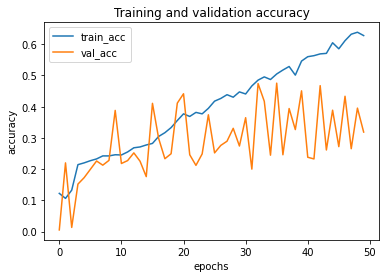

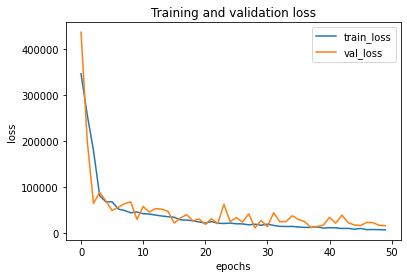

In [82]:
plot_accuracy_loss(history)

In [ ]:
def Evaluation(model):
  results = model.evaluate([test_X_seqs,test_X_ims], test_Y, batch_size=64)
  print('test loss, test acc:', results)
Evaluation(model)

24/24 [==============================] - 1s 21ms/step - loss: 67.5026 - accuracy: 0.1813
test loss, test acc: [67.50257110595703, 0.18133333325386047]


In [ ]:
def predict(model):
  prediction = predict = model.predict([test_X_seqs,test_X_ims])
  
  # y_pred = []
  # for p in prediction:
  #   y_pred.append(np.argmax(p))
  # y_pred = np.array(y_pred)
  # print(np.where(y_pred == test_answer_indices))
  return prediction

def compare_truth_pred(prediction, num):
  index = np.argmax(prediction[num])
  if(index == num_classes -1):
    show_visualqa(test_qs[num],'نمیدونم', get_test_image_paths().get(test_image_ids[num]))
  else:
    show_visualqa(test_qs[num],all_answers[index], get_test_image_paths().get(test_image_ids[num]))
  show_visualqa(test_qs[num],test_answers[num], get_test_image_paths().get(test_image_ids[num]))

In [ ]:
pred = predict(model)

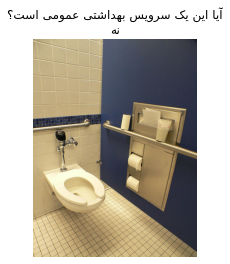

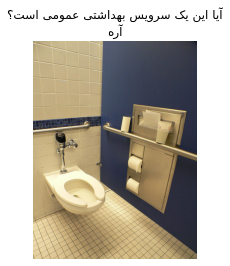

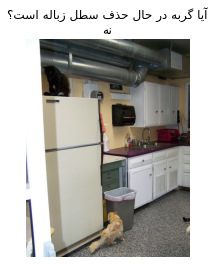

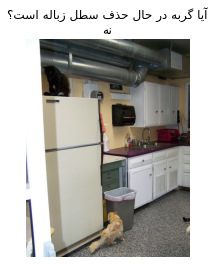

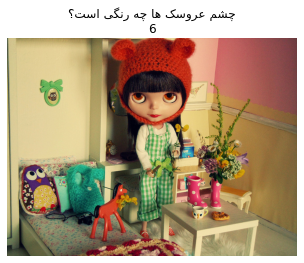

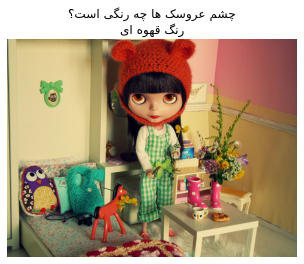

In [ ]:
compare_truth_pred(pred,60)
compare_truth_pred(pred,75)
compare_truth_pred(pred,711)

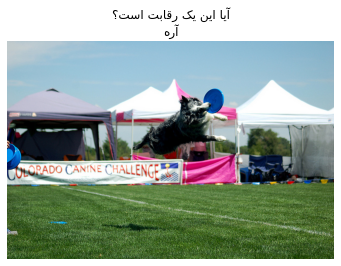

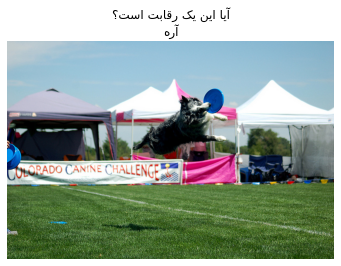

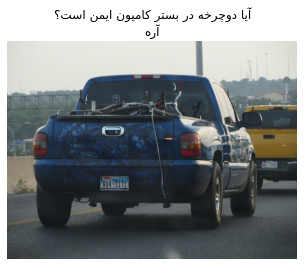

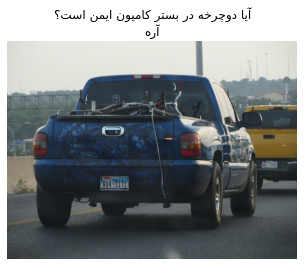

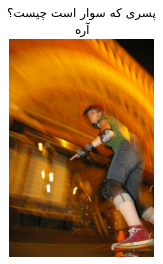

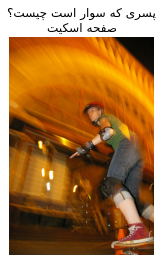

In [ ]:
compare_truth_pred(pred,0)
compare_truth_pred(pred,600)
compare_truth_pred(pred,800)